In [1]:
# Imports and setup
from pathlib import Path
import numpy as np
from icwaves.evaluation.evaluation import load_classifier, eval_classifier_per_subject_brain_F1
from icwaves.evaluation.config import EvalConfig
from icwaves.viz import plot_line_with_error_area
from icwaves.data.loading import get_data_and_feature_extractor
from icwaves.evaluation.iclabel import calculate_iclabel_f1_scores


In [ ]:
validation_times = np.r_[
    np.arange(10, 60 + 1, 10),
    np.arange(2 * 60, 5 * 60 + 1, 60),
    np.arange(5 * 60, 5 * 60 + 1, 60),
    np.arange(10 * 60, 50 * 60 + 1, 5 * 60),
]
root = Path().absolute().parent
mean_std_df = {}
for eval_dataset in ["cue", "emotion_study"]:
    mean_std_df[eval_dataset] = {}
    for feature_extractor_str in ["bowav", "psd_autocorr"]:
        mean_std_df[eval_dataset][feature_extractor_str] = {}
        # Configuration
        config = EvalConfig(
            train_dataset="emotion_study",
            eval_dataset=eval_dataset,  # {'cue', 'emotion_study'}
            feature_extractor=feature_extractor_str,  # {'bowav', 'psd_autocorr'}
            classifier_type="random_forest",  # {'logistic', 'random_forest'}
            validation_segment_length=300,
            root=root,
        )
        # Load data
        print(f"Getting data from {eval_dataset}, and building feature extractor for {feature_extractor_str}...")
        data_bundle, feature_extractor = get_data_and_feature_extractor(config)
        for classifier_type in ["random_forest", "logistic"]:
            config.classifier_type = classifier_type
            mean_std_df[eval_dataset][feature_extractor_str][classifier_type] = {}
            for validation_segment_len in [300, -1]:
                config.validation_segment_length = validation_segment_len
                print(f"Validation segment length: {validation_segment_len} | classifier type: {classifier_type}")
                # Load classifier
                clf, best_params = load_classifier(config)

                # Evaluate
                print("Computing F1 score...")
                mean_std_df[eval_dataset][feature_extractor_str][classifier_type][validation_segment_len] = eval_classifier_per_subject_brain_F1(
                    config,
                    clf,
                    feature_extractor,
                    validation_times,
                    data_bundle,
                    best_params["input_or_output_aggregation_method"],
                    best_params["training_segment_length"],
                )

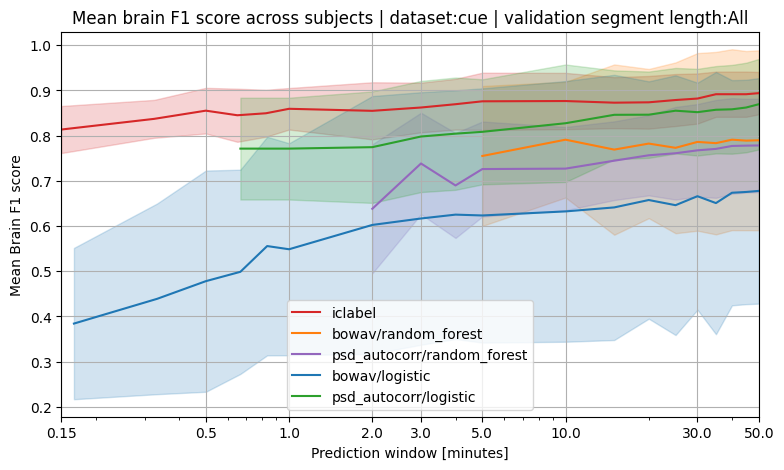

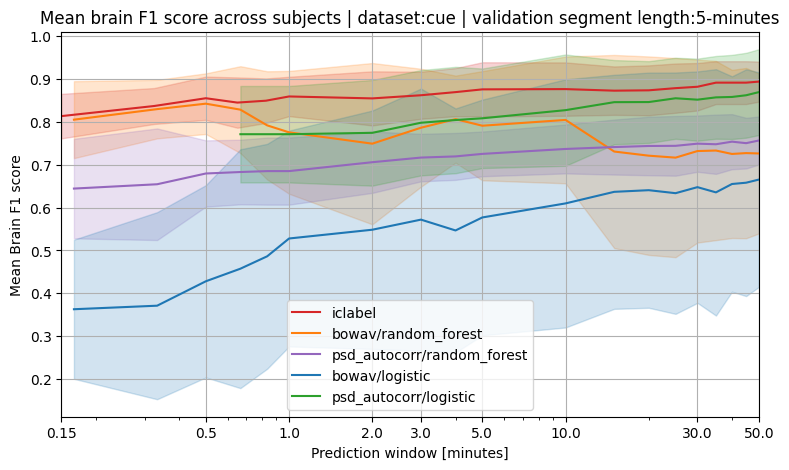

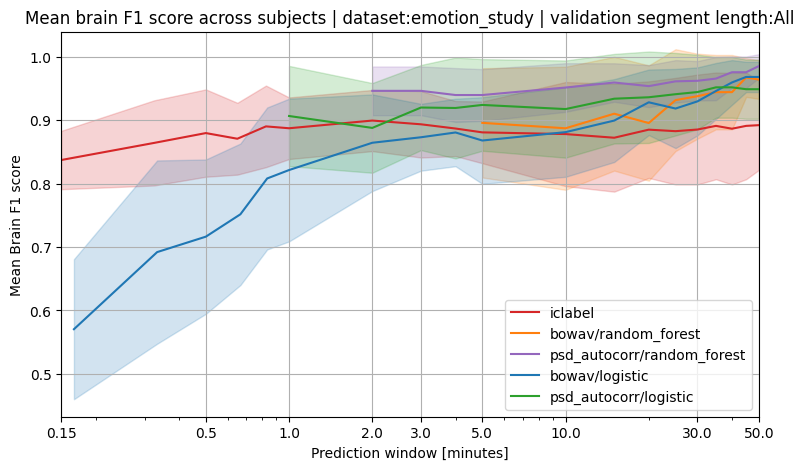

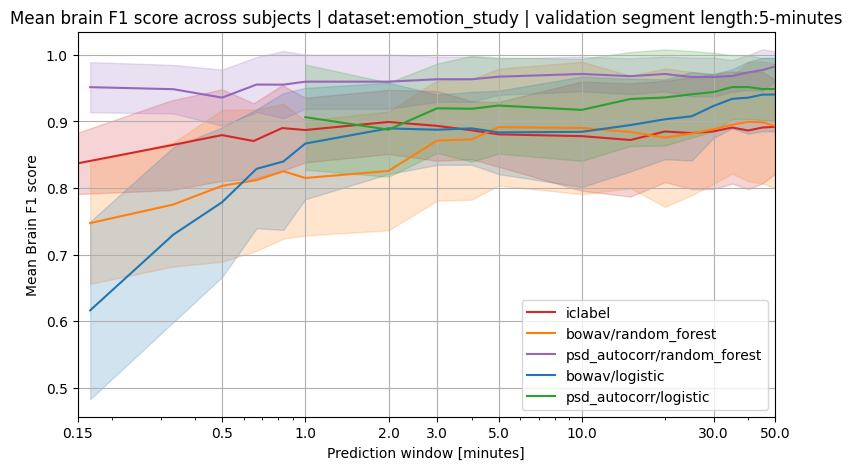

In [10]:
import matplotlib.pyplot as plt
global_x_ticks = np.array([0.15, 0.5, 1, 2, 3, 5, 10, 30, 50])
colors = {"bowav/logistic": "blue", "psd_autocorr/logistic": "green", "bowav/random_forest": "orange", "psd_autocorr/random_forest": "purple"}
val_seg_len_map = {-1: "All", 300: "5-minutes"}
for eval_dataset in ["cue", "emotion_study"]:
    # For ICLabel, the values for feature_extractor, classifier_type, train_dataset, and validation_segment_length
    # don't matter, as they are not used.
    config = EvalConfig(
        train_dataset="emotion_study",
        eval_dataset=eval_dataset,  # {'cue', 'emotion_study'}
        feature_extractor="bowav",
        classifier_type="logistic",  # {'logistic', 'random_forest'}
        validation_segment_length=-1,
        root=root,
    )
    # The *.mat files with the ICLabel labels were manually created for the following prediction times
    #     9.0,    19.5,    30.0,    39.0,    49.5
    #    60.0,   120.0,   180.0,   240.0,   300.0
    #   300.0,   600.0,   900.0,  1200.0,  1500.0
    #  1800.0,  2100.0,  2400.0,  2700.0,  3000.0
    validation_times_ = 1.5 * (validation_times // 1.5)
    iclabel_df = calculate_iclabel_f1_scores(config, validation_times_)
    iclabel_df = iclabel_df.rename(
            columns={
                "Brain F1 score - iclabel": "iclabel",
            }
        )
    # min_x_tick = -np.inf
    for validation_segment_len in [-1, 300]:
        fig, ax = plt.subplots(figsize=(9, 5))
        ax = plot_line_with_error_area(
            ax,
            iclabel_df,
            "Prediction window [minutes]",
            "iclabel",
            "StdDev - iclabel",
            color="red"
        )
        for classifier_type in ["random_forest", "logistic"]:
            for feature_extractor_str in ["bowav", "psd_autocorr"]:
                df = mean_std_df[eval_dataset][feature_extractor_str][classifier_type][validation_segment_len]
                # rename columns to also include the classifier type (e.g., "Brain F1 score - bowav" -> "Brain F1 score - bowav-logistic")
                df = df.rename(
                    columns={
                        "Brain F1 score - " + feature_extractor_str: f"{feature_extractor_str}/{classifier_type}",
                        "StdDev - " + feature_extractor_str: f"StdDev - {feature_extractor_str}/{classifier_type}"
                    }
                )
                ax = plot_line_with_error_area(
                    ax,
                    df,
                    "Prediction window [minutes]",
                    f"{feature_extractor_str}/{classifier_type}",
                    f"StdDev - {feature_extractor_str}/{classifier_type}",
                    color=colors[f"{feature_extractor_str}/{classifier_type}"]
                )
                # min_x_tick = max(min_x_tick, df["Prediction window [minutes]"].min())
        ax.set_xscale("log")
        # x_ticks = global_x_ticks[np.asarray(global_x_ticks >= min_x_tick).nonzero()]
        # ax.set_xticks(x_ticks, labels=x_ticks)
        ax.set_xticks(global_x_ticks, labels=global_x_ticks)
        # ax.set_xlim(min_x_tick, 50)
        ax.set_xlim(global_x_ticks[0], 50)
        ax.set_xlabel("Prediction window [minutes]")
        ax.set_ylabel("Mean Brain F1 score")
        ax.set_title(f"Mean brain F1 score across subjects | dataset:{eval_dataset} | validation segment length:{val_seg_len_map[validation_segment_len]}")
        ax.legend()
        ax.grid(True)